In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
df.columns = [
    'CRIM', 
    'ZN', 
    'INDUS', 
    'CHAS',
    'NOX', 
    'RM', 
    'AGE', 
    'DIS', 
    'RAD',
    'TAX', 
    'PTRATIO', 
    'B', 
    'LSTAT', 
    'MEDV'
]

In [2]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


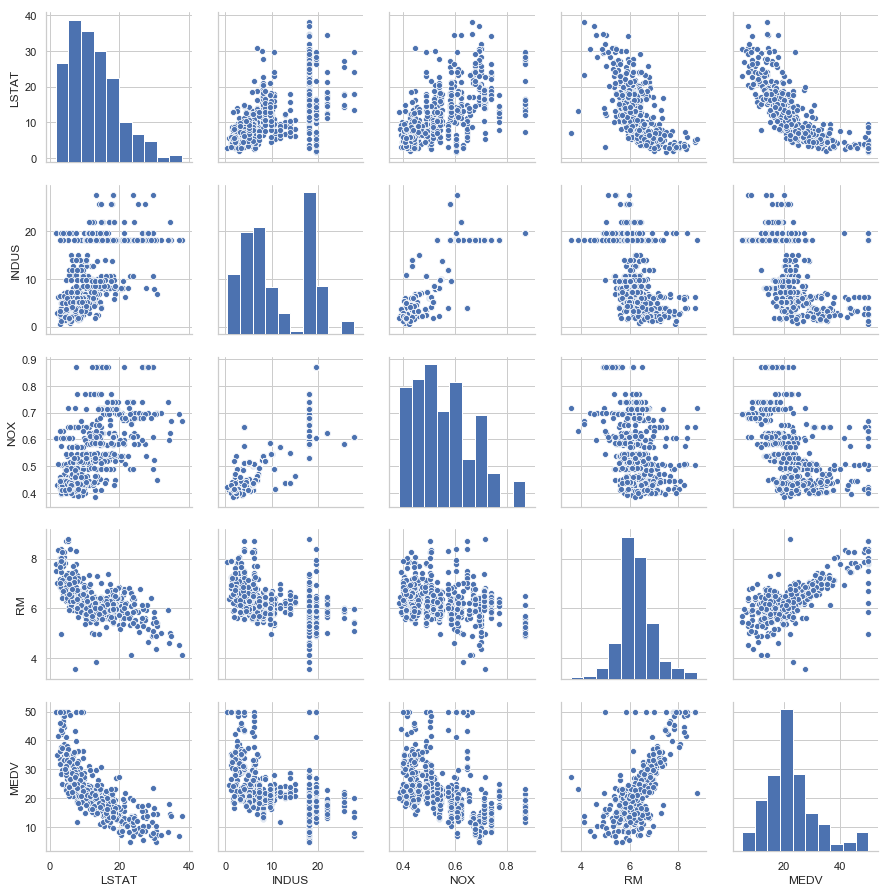

In [3]:
# Exploratory Data Analysis (EDA)

# scatter plots
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], height=2.5)
# sns.pairplot(df, height=2.5)

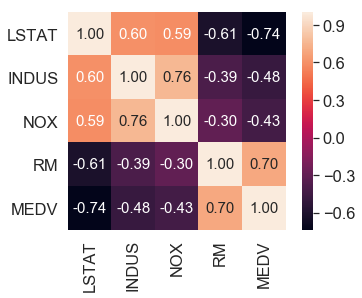

In [4]:
# correlations
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(
    cm,
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
    annot_kws={'size': 15},
    yticklabels=cols,
    xticklabels=cols
)

In [5]:
# changed from Adaline in ch2
class LinearRegressionGD:
    def __init__(self, eta=0.001, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self, X, y):
        n_rows, n_factors = X.shape
        self.weights = np.zeros(n_factors + 1)
        self.costs = [] # keep track of cost per iter
        
        for i in range(self.n_iter):
            output = self.net_input(X) # all_predictions
            errors = y - output # an array of all prediction vs target results
            # instead of looping through each row, update weight with result of all rows
            self.weights[1:] += self.eta * X.T.dot(errors) 
            self.weights[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0 # cost fuction: sum of square means / 2; note: I believe the divison by 2 is not a must, it just allows the differentiation function to not carry any multiple
            self.costs.append(cost)
        return self
    
    # returns a float value
    def net_input(self, X):
        return np.dot(X, self.weights[1:]) + self.weights[0] # dot product plus constant
    
    # for predicting a test set
    def predict(self, X):
        return self.net_input(X)

In [6]:
X = df[['RM']].values # need to be a matrix
y = df[['MEDV']].values

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)[:,0]

lr = LinearRegressionGD()
lr.fit(X_std, y_std)


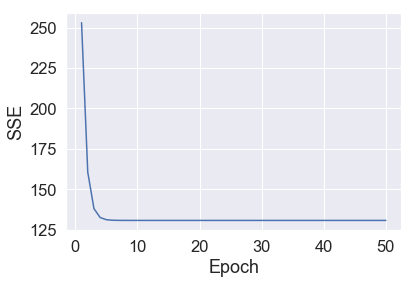

In [7]:
plt.plot(range(1, lr.n_iter+1), lr.costs)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [8]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

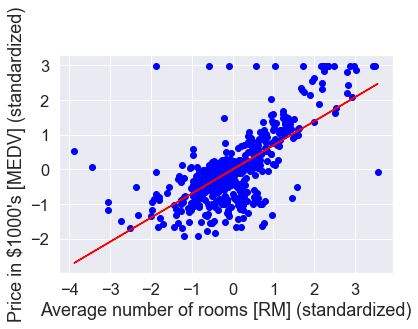

In [9]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [10]:
print('Slope: %.3f' % lr.weights[1])
print('Intercept: %.3f' % lr.weights[0])

Slope: 0.695
Intercept: -0.000


In [11]:
# get original value
num_rooms_std = sc_x.transform([[5.0]])
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


Text(0,0.5,"Price in $1000's [MEDV]")

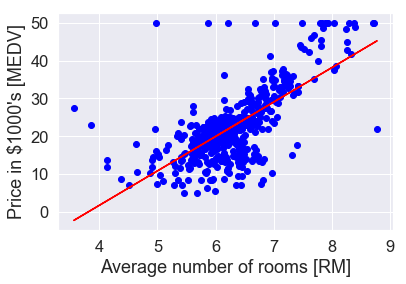

In [12]:
# plot of original value
plt.scatter(X, y, c='blue')
plt.plot(X, sc_y.inverse_transform(lr.predict(X_std)), color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')

Slope: 9.102
Intercept: -34.671


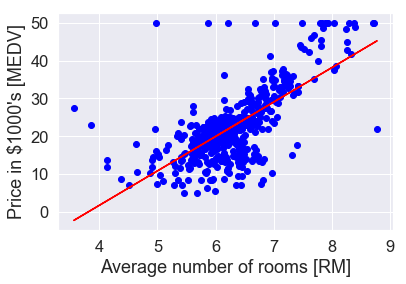

In [13]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)

lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

In [14]:
# Fitting with outlier-detection - RANdom SAmple Consensus (RANSAC)

from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100,
    min_samples=50,
    residual_metric=lambda x: np.sum(np.abs(x), axis=1),
    residual_threshold=5.0, # only allow samples to be included in the inlier set if their vertical distance to the fitted line is within 5 distance units
    random_state=0
)
ransac.fit(X, y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ransac.py:288: DeprecationWarning: 'residual_metric' was deprecated in version 0.18 and will be removed in version 0.20. Use 'loss' instead.
  DeprecationWarning)


RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=<function <lambda> at 0x1a2288f268>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

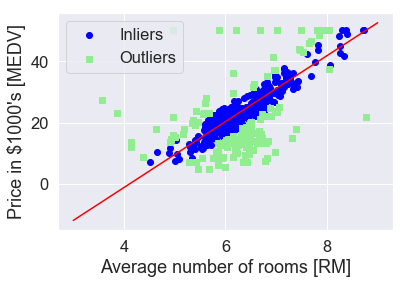

In [15]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis]) # ransac.predict expets matrix, i.e. [[3],[4],[5]...[9]]
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [16]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


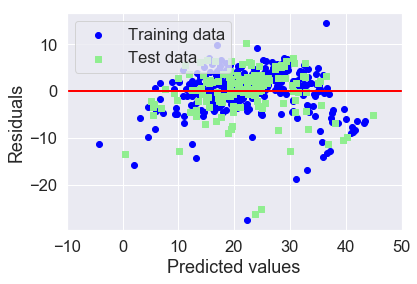

In [18]:
# Evaluating performance of linear regression model 


from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

# Residual Plot
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
# overfitting the training set

MSE train: 19.958, test: 27.196


In [20]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))
# perfect R^2 is 1; R^2 is inversely related to MSE

R^2 train: 0.765, test: 0.673


In [44]:
# Regularization methods
# Note: for this data, it seems to be getting WORSE
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)
print("Ridge Regression Model")
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))
    
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print("Lasso Regression Model")
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

from sklearn.linear_model import ElasticNet
net = ElasticNet(alpha=1.0, l1_ratio=0.5) # meaning, l1 to l2 standardization 1:1
net.fit(X_train, y_train)
y_train_pred = net.predict(X_train)
y_test_pred = net.predict(X_test)
print("Elastic Net Regression Model")
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Ridge Regression Model
R^2 train: 0.762, test: 0.667
Lasso Regression Model
R^2 train: 0.708, test: 0.612
Elastic Net Regression Model
R^2 train: 0.712, test: 0.617


In [48]:
# Polynomial Regression - example
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)
X_quad

array([[1.00000e+00, 2.58000e+02, 6.65640e+04],
       [1.00000e+00, 2.70000e+02, 7.29000e+04],
       [1.00000e+00, 2.94000e+02, 8.64360e+04],
       [1.00000e+00, 3.20000e+02, 1.02400e+05],
       [1.00000e+00, 3.42000e+02, 1.16964e+05],
       [1.00000e+00, 3.68000e+02, 1.35424e+05],
       [1.00000e+00, 3.96000e+02, 1.56816e+05],
       [1.00000e+00, 4.46000e+02, 1.98916e+05],
       [1.00000e+00, 4.80000e+02, 2.30400e+05],
       [1.00000e+00, 5.86000e+02, 3.43396e+05]])

In [49]:
lr.fit(X, y)
X_fit = np.arange(250,600,10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

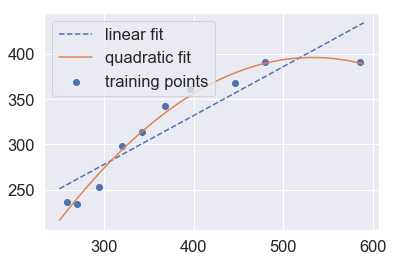

In [51]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

In [53]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (mean_squared_error(y, y_lin_pred), mean_squared_error(y, y_quad_pred)))
print('Training  R^2 linear: %.3f, quadratic: %.3f' % (r2_score(y, y_lin_pred), r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training  R^2 linear: 0.832, quadratic: 0.982


In [54]:
X = df[['LSTAT']].values
y = df['MEDV'].values
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis] # plot continuous points for reference
   
# linear fit
regr = LinearRegression()
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

# quadratic fit
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

# cubic fit
cubic = PolynomialFeatures(degree=3)
X_cubic = cubic.fit_transform(X)
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

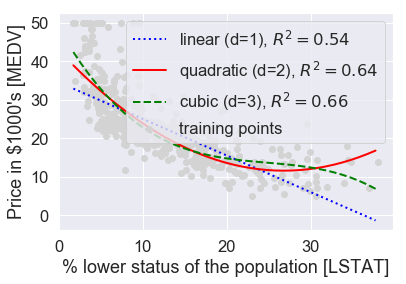

In [55]:
plt.scatter(X, y, label='training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='linear (d=1), $R^2=%.2f$' % linear_r2, color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2, color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label='cubic (d=3), $R^2=%.2f$' % cubic_r2, color='green', lw=2, linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')
plt.show()

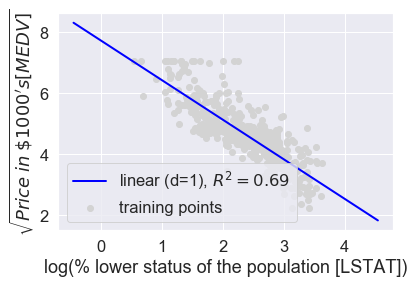

In [56]:
# transform features - log, sqrt

X_log = np.log(X)
y_sqrt = np.sqrt(y)

X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='linear (d=1), $R^2=%.2f$' % linear_r2, color='blue', lw=2)
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')
plt.show()

In [81]:
# Random forests
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

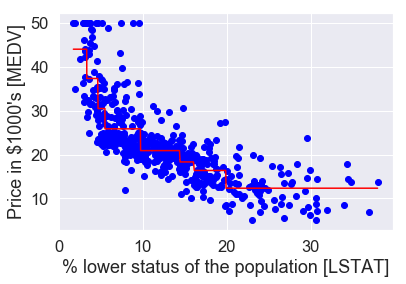

In [82]:
sort_idx = X.flatten().argsort() # index of X sorted, so plots a continuous line when using #lin_regplot
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

In [84]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)                            
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


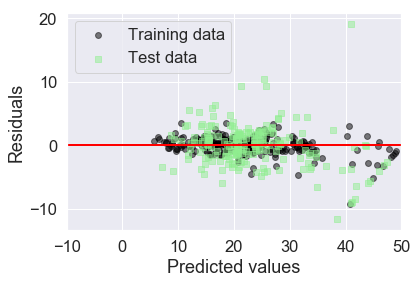

In [86]:
plt.scatter(
  y_train_pred,
  y_train_pred - y_train,
  c='black',
  marker='o',
  s=35,
  alpha=0.5,
  label='Training data'
)
plt.scatter(
  y_test_pred,
  y_test_pred - y_test,
  c='lightgreen',
  marker='s',
  s=35,
  alpha=0.5,
  label='Test data'
)
plt.ylabel('Residuals')
plt.xlabel('Predicted values')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()